## CPE 4903 - Prediction of Time Series: RNN ##
Predict [y(t+n)] given x(t-time_steps)...x(t), x(t) = [1 2 3 4 5 4 3 2 1 2 3 ...] sawtooth

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from keras.models import Model, Sequential
import pandas as pd
#import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
import os  # avoid kernal die
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
def plot_loss(history, title):
# summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss: ' + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    print('MSE val = ', history.history['val_loss'][-1])

In [4]:
def plot_y_yhat(x_test, y_test, model, title):
#y_pred = model.predict(X_test)
    y_hat = model.predict(x_test)
    Time_test = np.arange(0, len(y_hat))
    plt.figure(figsize=(20,10))
    plt.plot(Time_test, y_hat, '-+', Time_test, y_test)
    plt.legend(['Predicted', 'True'], loc='upper right')
    plt.title('Y vs Yhat: ' + title)
    results = model.evaluate(x_test, y_test)
    print("test loss, test acc:", results)

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
if True: #sawtooth waveform
    x = np.array([1, 2, 3, 4, 5, 4, 3, 2, 1, 2, 3, 4, 5, 4, 3, 2, 1, 2, 3, 4, 5, 4, 3, 2, 1, 2, 3, 4, 5, 4])
    x = x.reshape(-1,1)
else:
    time = np.arange(0, 100, 0.1)
    signal = np.sin(time) * np.sin(5*time + .25) + np.sin(.5*time + .35)
    noise = 0*np.random.normal(scale=0.5, size=len(time))
    data = signal + noise


In [7]:
x.shape

(30, 1)

In [8]:
x.T

array([[1, 2, 3, 4, 5, 4, 3, 2, 1, 2, 3, 4, 5, 4, 3, 2, 1, 2, 3, 4, 5, 4,
        3, 2, 1, 2, 3, 4, 5, 4]])

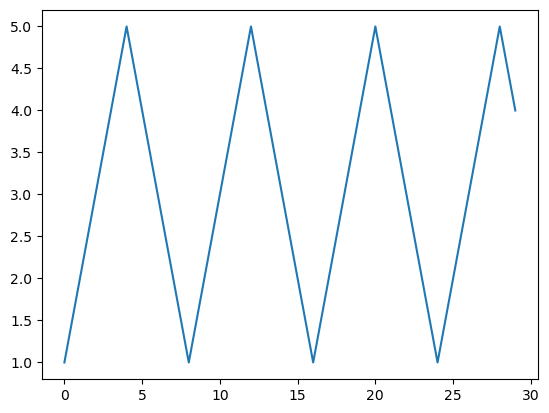

In [9]:
plt.plot(x)

In [10]:
train_size = int(len(x) * 0.7)
test_size = len(x) - train_size
train = x[:train_size]
test = x[train_size:]

train = train.reshape(-1,1)
test = test.reshape(-1,1)
print(train.shape, test.shape)

# simple scaling
#train = train/np.max(train)
#test = test/np.max(test)

(21, 1) (9, 1)


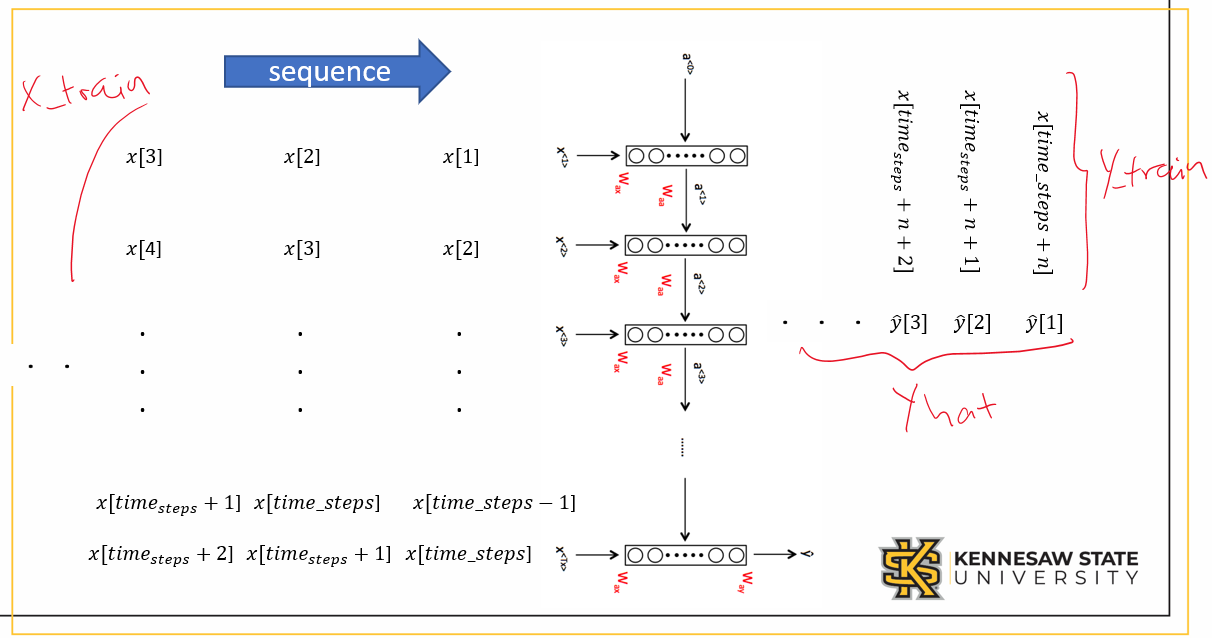

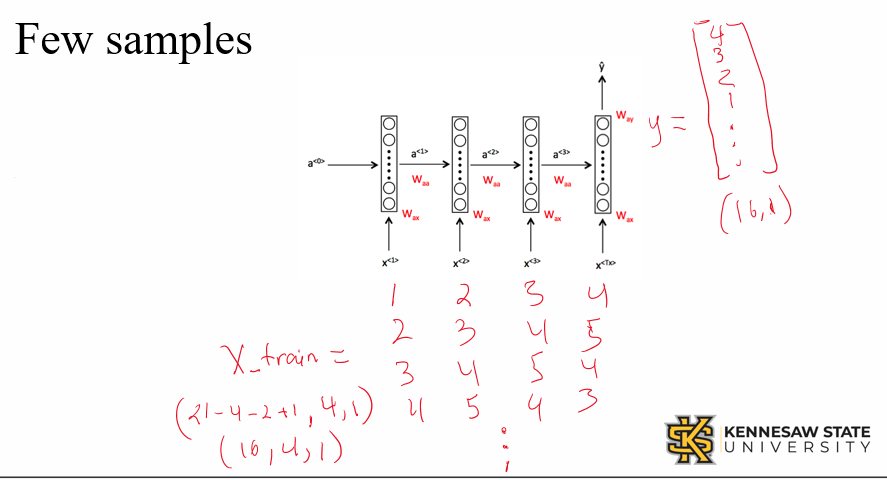

In [11]:
time_steps =4
n = 2 # prediction y(t+n) ahead
# Train sets
m_train = len(train)
m_star = m_train - time_steps - n +1
X_train =np.zeros((m_star, time_steps))
y_train = np.zeros((m_star, 1))
#X_train.shape
for i in range(m_star):
    X_train[i,:] = train[i:i+time_steps].flatten()
    y_train[i] = train[i+time_steps-1+n]

# Test sets
m_test = len(test)
m_star = m_test - time_steps - n +1
X_test =np.zeros((m_star, time_steps))
y_test = np.zeros((m_star, 1))
#X_test.shape
for i in range(m_star):
    X_test[i,:] = test[i:i+time_steps].flatten()
    y_test[i] = test[i+time_steps-1+n]

In [12]:
print('X_train and y_train shapes: ', [X_train.shape, y_train.shape])
print('X_test and y_test shapes: ', [X_test.shape, y_test.shape])

X_train and y_train shapes:  [(16, 4), (16, 1)]
X_test and y_test shapes:  [(4, 4), (4, 1)]


In [13]:
m_train-time_steps-n+1

16

In [14]:
X_train

array([[1., 2., 3., 4.],
       [2., 3., 4., 5.],
       [3., 4., 5., 4.],
       [4., 5., 4., 3.],
       [5., 4., 3., 2.],
       [4., 3., 2., 1.],
       [3., 2., 1., 2.],
       [2., 1., 2., 3.],
       [1., 2., 3., 4.],
       [2., 3., 4., 5.],
       [3., 4., 5., 4.],
       [4., 5., 4., 3.],
       [5., 4., 3., 2.],
       [4., 3., 2., 1.],
       [3., 2., 1., 2.],
       [2., 1., 2., 3.]])

In [15]:
y_train

array([[4.],
       [3.],
       [2.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [4.],
       [3.],
       [2.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.]])

In [16]:
x

array([[1],
       [2],
       [3],
       [4],
       [5],
       [4],
       [3],
       [2],
       [1],
       [2],
       [3],
       [4],
       [5],
       [4],
       [3],
       [2],
       [1],
       [2],
       [3],
       [4],
       [5],
       [4],
       [3],
       [2],
       [1],
       [2],
       [3],
       [4],
       [5],
       [4]])

In [17]:
m = len(y_train)
nx = 1 # dim of x<t>
print('m, time_steps, n = look_ahead, nx: ', m, time_steps, n, nx)



m, time_steps, n = look_ahead, nx:  16 4 2 1


In [23]:
# RNN #
hidden_neurons = 90
model = Sequential()
model.add(SimpleRNN(units=hidden_neurons, input_shape=(time_steps, nx)))
model.add(Dense(units=1, activation='linear'))
opt=keras.optimizers.Adam()

model.compile(loss='mean_squared_error',optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 90)                8280      
                                                                 
 dense_1 (Dense)             (None, 1)                 91        
                                                                 
Total params: 8,371
Trainable params: 8,371
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/150
1/1 [==============================] - 1s 873ms/step - loss: 8.5200 - val_loss: 15.3853
Epoch 2/150
1/1 [==============================] - 0s 25ms/step - loss: 6.3911 - val_loss: 12.4776
Epoch 3/150
1/1 [==============================] - 0s 25ms/step - loss: 4.7164 - val_loss: 9.9630
Epoch 4/150
1/1 [==============================] - 0s 26ms/step - loss: 3.4808 - val_loss: 7.8379
Epoch 5/150
1/1 [==============================] - 0s 26ms/step - loss: 2.6487 - val_loss: 6.0898
Epoch 6/150
1/1 [==============================] - 0s 27ms/step - loss: 2.1664 - val_loss: 4.6987
Epoch 7/150
1/1 [==============================] - 0s 25ms/step - loss: 1.9635 - val_loss: 3.6371
Epoch 8/150
1/1 [==============================] - 0s 26ms/step - loss: 1.9568 - val_loss: 2.8671
Epoch 9/150
1/1 [==============================] - 0s 24ms/step - loss: 2.0572 - val_loss: 2.3395
Epoch 10/150
1/1 [==============================] - 0s 25ms/step - loss: 2.1843 - val_loss: 2.0011
Epoch 11/150
1/1

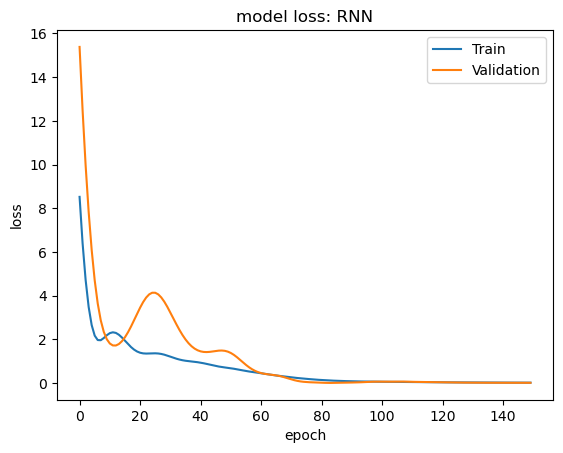

MSE val =  0.007033746689558029
1/1 [==============================] - 0s 20ms/step - loss: 0.0121
test loss, test acc: 0.012072255834937096


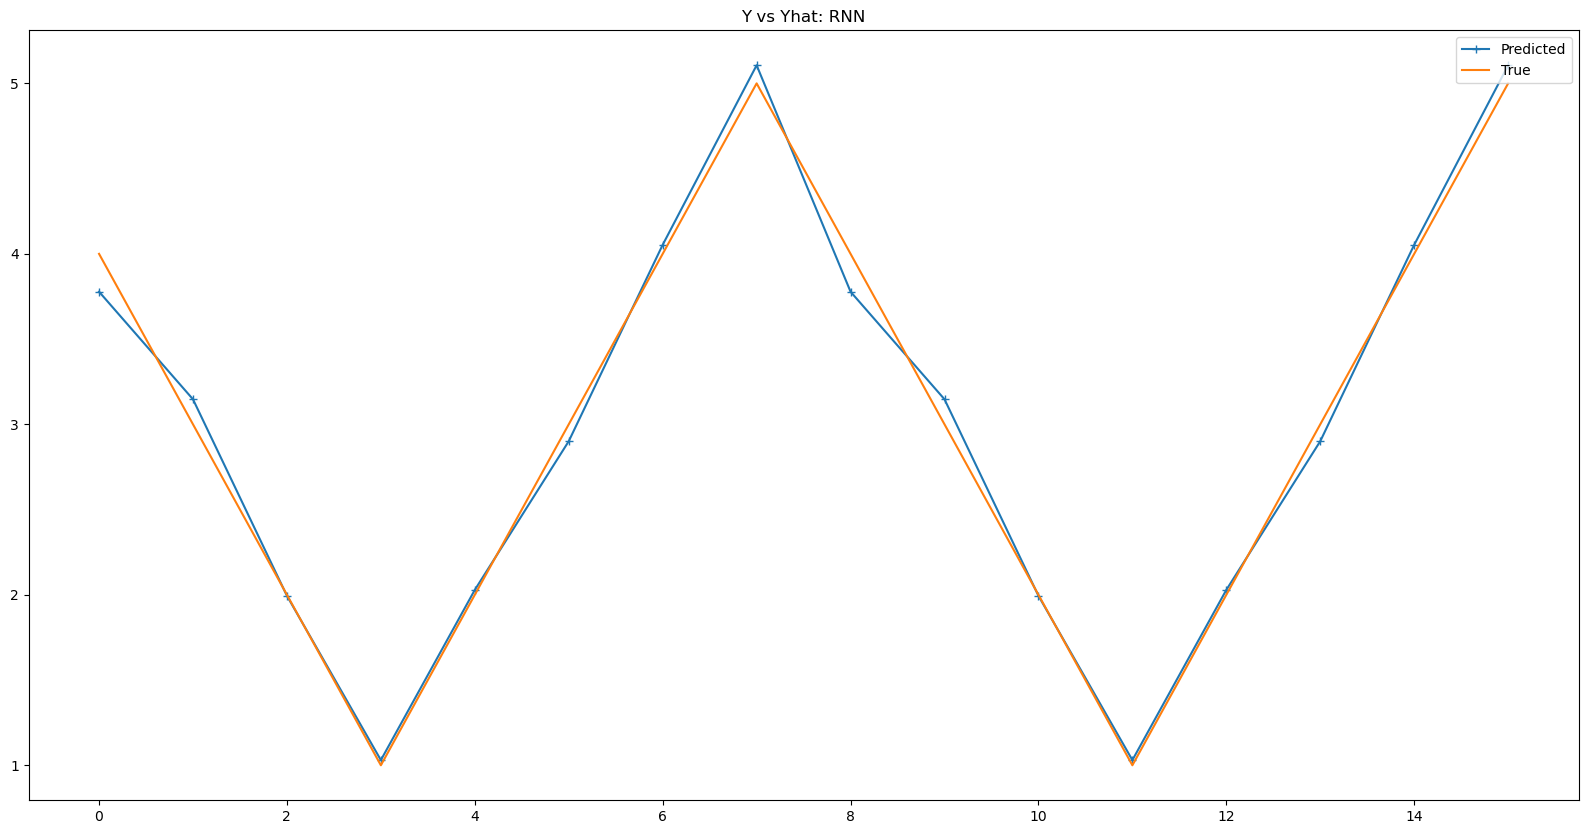

In [25]:
plot_loss(history, 'RNN')

plot_y_yhat(X_train, y_train, model, 'RNN')   # runs model.predict in function

In [26]:
yhat_test = model.predict(X_test)

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 20ms/step - loss: 0.0183
test loss, test acc: 0.01831328310072422


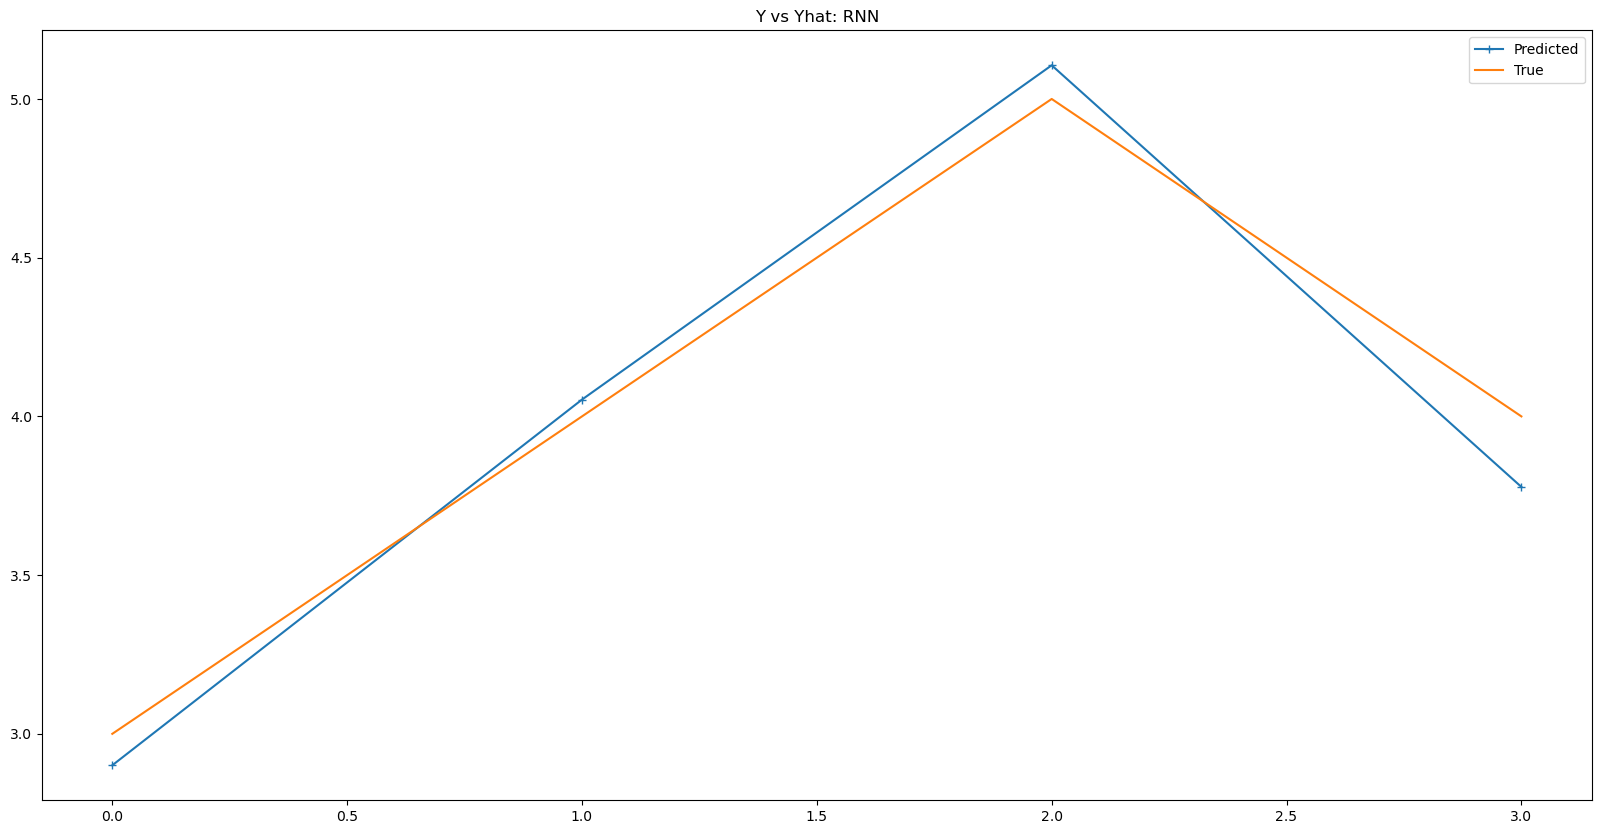

In [27]:

plot_y_yhat(X_test, y_test, model, 'RNN')   # runs model.predict in function